In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import json
from datetime import datetime

path = 'res1.json'
pub_stat = [[] for i in range(2)]
pub_date = []
pub_hour = np.zeros((24))
pub_hour_bud = np.zeros((24))
pub_hour_week = np.zeros((24))
qart = 0
text = ''
k = 0
with open(path, 'r') as f:
    data = json.loads(f.read())
    for i in data:
        datef = datetime.strptime(i['date'], '%Y-%m-%d %H:%M:%S')
        ind = 1
        for p in pub_date:
            if p.year == datef.year and p.month == datef.month and p.day == datef.day:
                k = pub_date.index(p)
                pub_stat[0][k] += 1
                ind = 0
                break
        if ind:
            pub_date.append(datef)
            pub_stat[0].append(1)
            pub_stat[1].append(datef.weekday())
            
        qart += 1
        text += i['text']
        pub_hour[datef.hour] += 1
        if datef.weekday() in (0,1,2,3,4):
            pub_hour_bud[datef.hour] += 1
        else:
            pub_hour_week[datef.hour] += 1
            
pub_stat = np.asarray(pub_stat)
pub_stat = pub_stat.T
if k != 0:
    av_pub_per_day = int(round(pub_stat[0].mean()))
else:
    av_pub_per_day = pub_stat[0][0]
budq, bud, weekd, weekdq = 0, 0, 0, 0
for i in pub_stat:
    if i[1] in (0,1,2,3,4):
        bud += i[0]
        budq += 1
    else:
        weekd += i[0]
        weekdq += 1
print("Количество публикаций в исследуемый период на ресурсе: ", qart)
print("Среднее количество публикаций в день в исследуемый период : ", av_pub_per_day)
if weekdq:
    av_pub_per_weekd = int(round(weekd/weekdq))
    print("Среднее количество публикаций в выходной день в исследуемый период : ", av_pub_per_weekd)
if budq:
    av_pub_per_bud = int(round(bud/budq))
    print("Среднее количество публикаций в будний день в исследуемый период : ", av_pub_per_bud)

Количество публикаций в исследуемый период на ресурсе:  183
Среднее количество публикаций в день в исследуемый период :  6
Среднее количество публикаций в выходной день в исследуемый период :  1
Среднее количество публикаций в будний день в исследуемый период :  9


Как показано выше, количество новостей, опубликованных на ресурсе за день, сильно зависит от того, являлся ли этот день выходным. Соответственно, если мы хотим непрерывно собирать данные, то имеет смысл менять частоту сбора в зависимости от того, является ли день сбора выходным. Также, нужно понять, в какое время и как часто собирать данные. Определим, какие часы является наиболее популярным для публикаций. Построим соответствующие графики для всех дней января, для будней и для выходных.

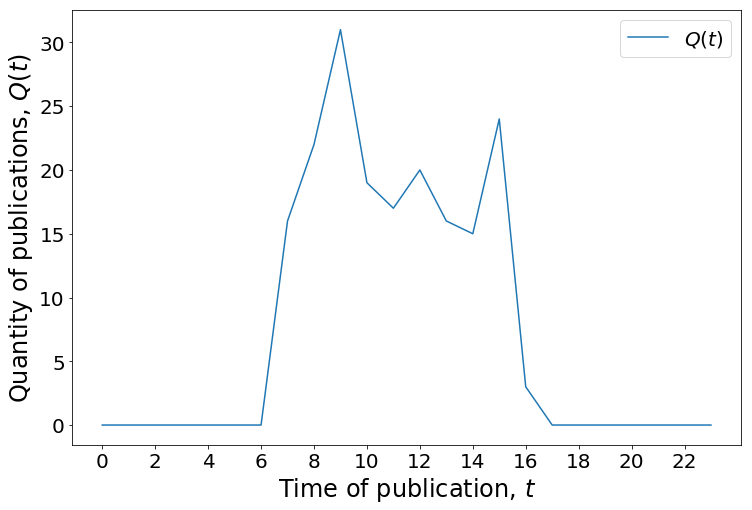

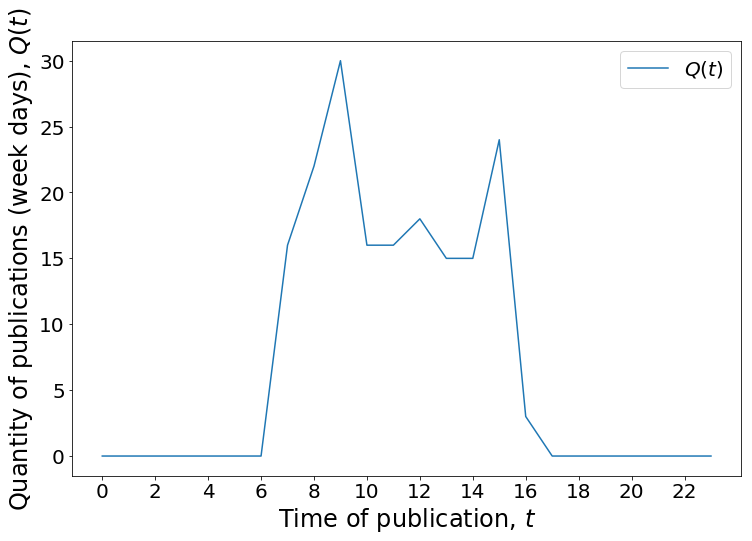

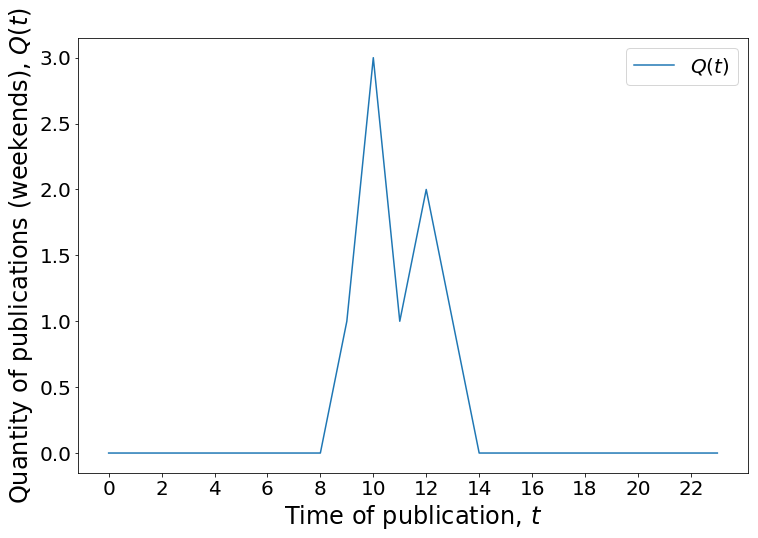

In [176]:
arg = np.array([ k for k in range(24)])
plt.figure(figsize=(12,8))
plt.plot(arg,pub_hour, label=r"$Q(t)$")
plt.xlabel("Time of publication, $t$", fontsize=24)
plt.ylabel("Quantity of publications, $Q(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.xticks(np.arange(min(arg), max(arg)+1, 2.0))
plt.show()

arg = np.array([ k for k in range(24)])
plt.figure(figsize=(12,8))
plt.plot(arg,pub_hour_bud, label=r"$Q(t)$")
plt.xlabel("Time of publication, $t$", fontsize=24)
plt.ylabel("Quantity of publications (week days), $Q(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.xticks(np.arange(min(arg), max(arg)+1, 2.0))
plt.show()

arg = np.array([ k for k in range(24)])
plt.figure(figsize=(12,8))
plt.plot(arg,pub_hour_week, label=r"$Q(t)$")
plt.xlabel("Time of publication, $t$", fontsize=24)
plt.ylabel("Quantity of publications (weekends), $Q(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.xticks(np.arange(min(arg), max(arg)+1, 2.0))
plt.show()

* Первые два графика мало чем отличаются, что нормально, учитывая, что подавляющее большинство публикаций производилось в будние дни. Из них видно, что, больше всего публикаций происходит в десятом, первом и четвертом часу. Также, новости начинают появляться в восьмом часу и прекращаются шестом. Тогда, я бы предложил собирать информацию три раза в день: в десять, два и пять часов. Такая частота сбора позволит всегда иметь достаточно актуальную информацию, с задержкой максимум в четыре часа.
* Учитывая то, что на выходных публикуется в среднем одна новость, я бы предложил собирать информацию один раз в день в два часа, так как не было ни одной статьи за месяц, опубликованной позже. Но если мы боимся узнать о чем-то важном слишком поздно, то можно делать сбор два раза: в одинадцать и два.

### Построим word cloud по текстам статей:

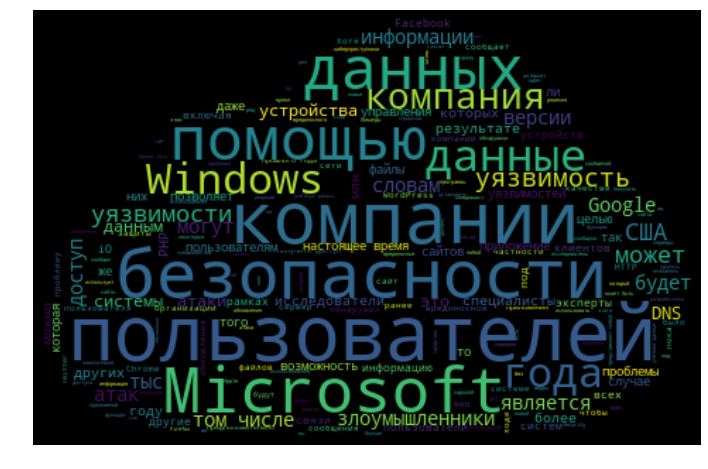

In [177]:
import os

from os import path
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

mask = np.array(Image.open(path.join(d, "cloud.png")))
wordcloud = WordCloud(stopwords = {'на', 'для','не','по','как','что','за','да','уже','но','их','он','их','также',
                                   'от','из','или','только','его','до','ее','еще','если','однако','через','при',
                                  'был','они','после','все','была','согласно','которые','были','том числе',
                                   'поскольку'},
                      mask = mask).generate(text)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Построим word cloud по текстам статей в виде логотипа сайта:

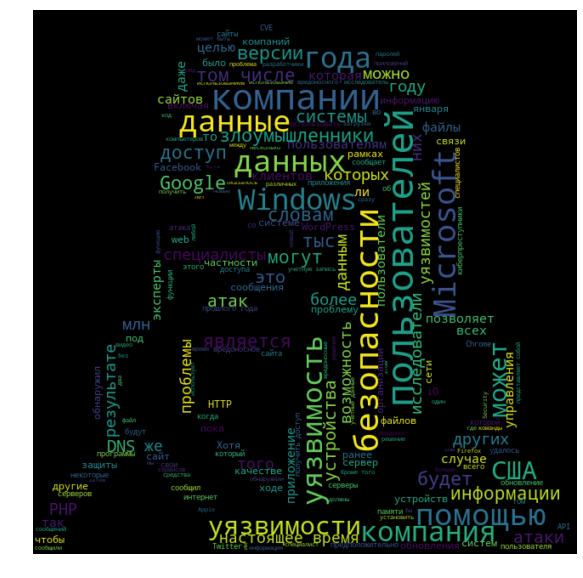

In [178]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

mask = np.array(Image.open(path.join(d, "logo.jpg"))) #Securitylab logo :)
wordcloud = WordCloud(stopwords = {'на', 'для','не','по','как','что','за','да','уже','но','их','он','их','также',
                                   'от','из','или','только','его','до','ее','еще','если','однако','через','при',
                                  'был','они','после','все','была','согласно','которые','были','том числе', 
                                   'поскольку'},
                      mask = mask).generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()